# PCA

In [19]:
import torch, torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn, sklearn.decomposition as decomp
import os

In [20]:
from sklearn.preprocessing import StandardScaler
# Separating out the features
path = "./tmp/embeddings/version_4"
path = "./tmp/embeddings/sc_version"
path = "./tmp/embeddings/version_8"
path = "./tmp/embeddings/sc_version"
labtr = np.load(os.path.join(path, "labtr.npy"))
labva = np.load(os.path.join(path, "labva.npy"))
outtr = np.load(os.path.join(path, "outtr.npy"))
outva = np.load(os.path.join(path, "outva.npy"))
# Standardizing the features

indices_tr = labtr != "EMPTY"
indices_va = labva != "EMPTY"
print(np.sum(indices_tr), np.sum(indices_va), len(indices_tr), len(indices_va))

purge_empty = True
if purge_empty:
    labtr = labtr[indices_tr]
    outtr = outtr[indices_tr]
    labva = labva[indices_va]
    outva = outva[indices_va]


x_tr = StandardScaler().fit_transform(outtr)
x_va = StandardScaler().fit_transform(outva)

print(x_tr.shape, x_va.shape)
print(np.sum(np.mean(x_tr, axis=0)), np.sum(np.std(x_tr, axis=0)))

44152 5568 57052 7171
(44152, 256) (5568, 256)
3.8794838e-07 255.99936


In [21]:
from collections import defaultdict
lab_tr_counter = defaultdict(int)

for v in labtr:
    lab_tr_counter[v] += 1

lab_frequencies = sorted(list(lab_tr_counter.items()), key = lambda x : -x[1])
print(lab_frequencies)
lab_frequencies = lab_frequencies[:10]
allow_classes, _ = zip(*lab_frequencies)

print(allow_classes)

[('Flavonoids', 4513), ('Small peptides', 3817), ('Steroids', 3130), ('Tryptophan alkaloids', 3069), ('Pseudoalkaloids', 2887), ('Tyrosine alkaloids', 1922), ('Anthranilic acid alkaloids', 1803), ('Coumarins', 1617), ('Ornithine alkaloids', 1447), ('Nucleosides', 1377), ('Nicotinic acid alkaloids', 1363), ('Sesquiterpenoids', 1261), ('Lysine alkaloids', 1181), ('Triterpenoids', 994), ('Diterpenoids', 904), ('Phenylpropanoids (C6-C3)', 875), ('Oligopeptides', 800), ('Phenolic acids (C6-C1)', 742), ('Saccharides', 716), ('Fatty Acids and Conjugates', 694), ('Monoterpenoids', 623), ('Lignans', 610), ('Isoflavonoids', 593), ('Peptide alkaloids', 557), ('Macrolides', 492), ('Polycyclic aromatic polyketides', 473), ('Fatty esters', 449), ('Meroterpenoids', 372), ('Linear polyketides', 371), ('Chromanes', 327), ('Aminosugars and aminoglycosides', 323), ('Fatty amides', 314), ('Histidine alkaloids', 304), ('Aromatic polyketides', 301), ('Cyclic polyketides', 248), ('Fatty acyls', 234), ('Napht

In [22]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
pca = PCA(n_components=3)
pca.fit(x_va)
print(pca.explained_variance_ratio_)
# x_tr_pc = pca.transform(x_tr)
x_va_pc = pca.transform(x_va)[:,:2]
x_va_pc3d = pca.transform(x_va)
print(x_va_pc3d.shape)

[0.24318689 0.13671057 0.09507156]
(5568, 3)


In [23]:
x_va_tsne = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(x_va)
x_va_tsne3d = TSNE(n_components=3, learning_rate='auto', init='random').fit_transform(x_va)

In [24]:
import umap
reducer = umap.UMAP()
embedding = reducer.fit_transform(x_va)
embedding.shape

(5568, 2)

In [25]:
import matplotlib.cm as cm
def plot(collection, title=""):
    fig = plt.figure(figsize = (16,16), frameon=True)
    fig.patch.set_facecolor('#E0E0E0')
    ax = fig.add_subplot(1,1,1) 
    ax.set_xlabel('Principal Component 1', fontsize = 15)
    ax.set_ylabel('Principal Component 2', fontsize = 15)
    ax.set_title(title, fontsize = 20)
    targets = list(set(labtr).union(set(labva)) - set(["EMPTY"])) 
    targets = allow_classes
    colors = cm.gist_rainbow(np.linspace(0, 1, len(targets)))

    for target, color in zip(targets,colors):
        ind = labva == target
        ax.scatter(collection[ind,0], collection[ind,1], color = color)
    ax.legend(targets)
    ax.grid()
    fig.show()
    plt.show()

C:\Users\James\anaconda3\envs\smart\lib\site-packages\ipykernel_launcher.py:18: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



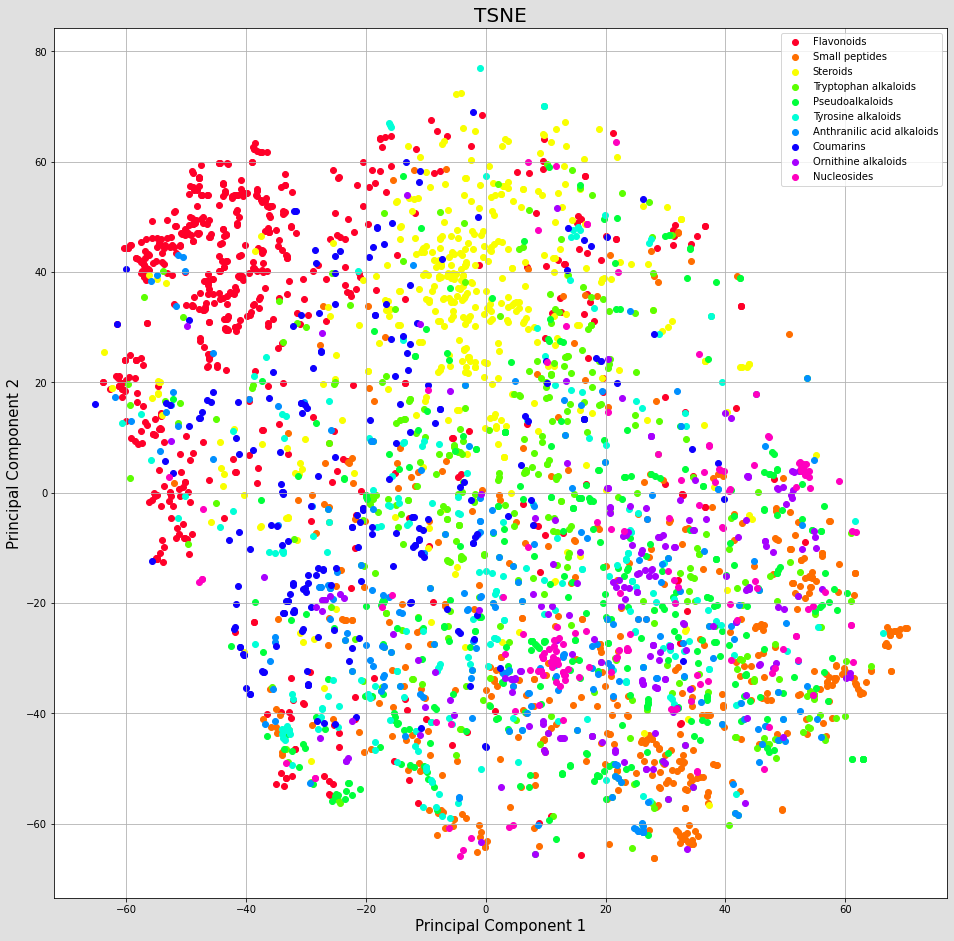

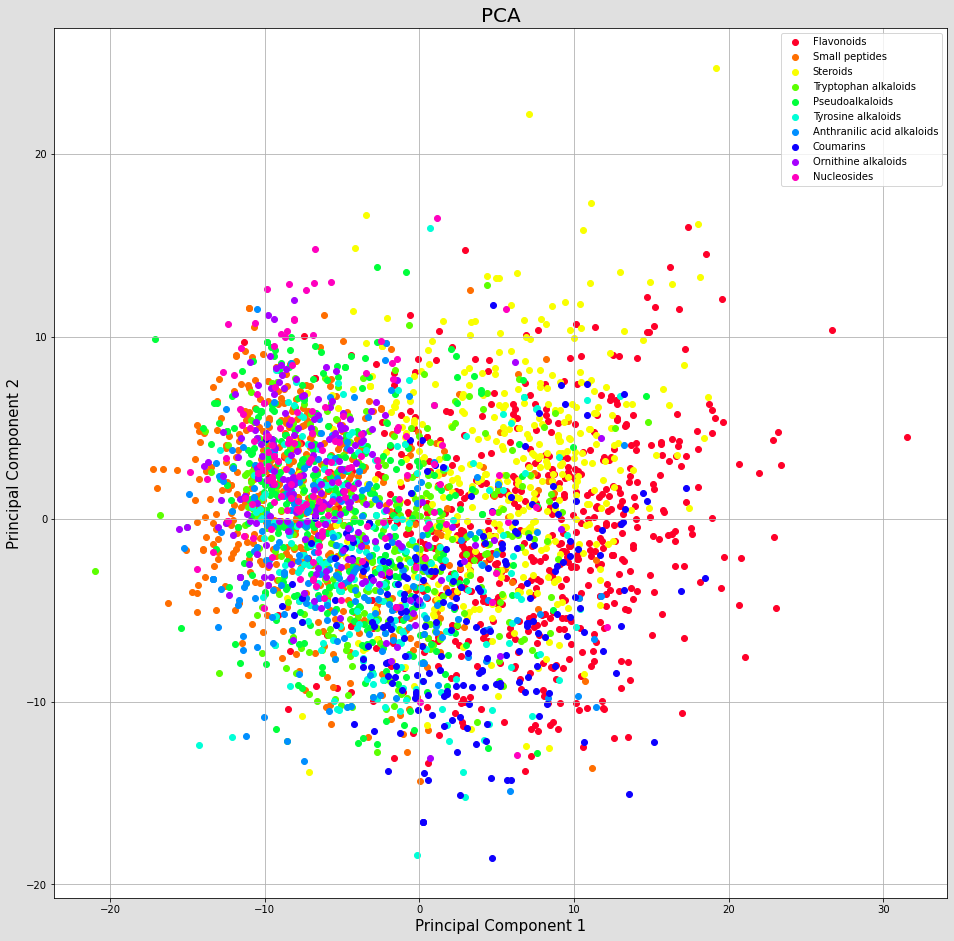

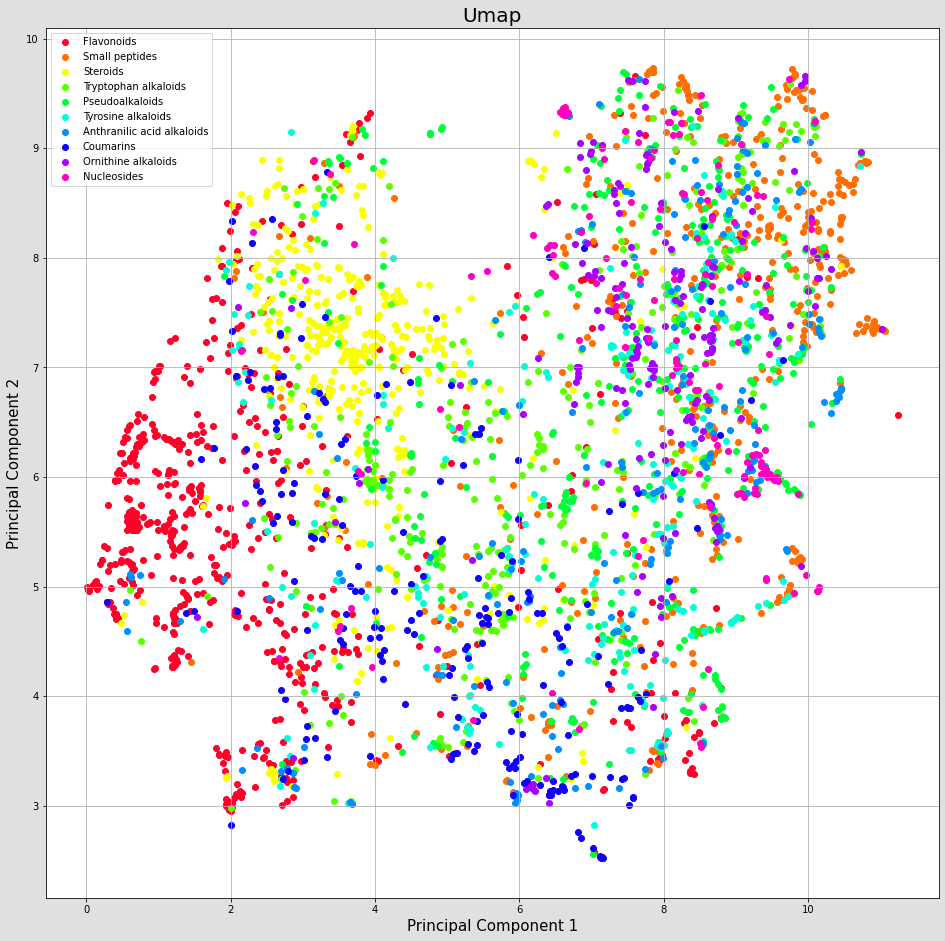

In [26]:
plot(x_va_tsne, "TSNE")
plot(x_va_pc, "PCA")
plot(embedding, "Umap")

In [27]:
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

In [33]:
# Load Data
df = px.data.tips()
# Build App
app = JupyterDash(__name__)

def get_fig(collection, title=""):
    targets = allow_classes
    colors = cm.gist_rainbow(np.linspace(0, 1, len(targets)))
    fil = lambda x : x in targets
    mask = np.array([x in targets for x in labva])
    samp_x = collection[mask]
    samp_y = labva[mask]
    fig = px.scatter_3d(
        samp_x, x=0, y=1, z=2, color=samp_y,
        title=title,
        labels={'0': 'PC 1', '1': 'PC 2', '2': 'PC 3'},
        size_max=15,
        size=[15] * len(samp_y)
    )
    fig.update_layout(height=1000)
    return fig
app.layout = html.Div([
    html.H1("JupyterDash Demo"),
    dcc.Graph(id='graph', figure=get_fig(x_va_pc3d, f'[PCA]: Total Explained Variance: {(sum(pca.explained_variance_ratio_)):.2f}%')),
    dcc.Graph(id='graph2', figure=get_fig(x_va_tsne3d, "TSNE")),
], style={"background-color": "white"})
# Define callback to update graph
    
# @app.callback(
#     Output('graph', 'figure'),
#     [Input("colorscale-dropdown", "value")]
# )
# def update_figure(colorscale):
#     return px.scatter(
#         df, x="total_bill", y="tip", color="size",
#         color_continuous_scale=colorscale,
#         render_mode="webgl", title="Tips"
#     )
# Run app and display result inline in the notebook
app.run_server(mode='external', port=9090)

Dash app running on http://127.0.0.1:9090/


In [29]:
app._terminate_server_for_port("localhost", 9090)

In [30]:
import tqdm, random
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import auc, roc_curve, roc_auc_score
from matplotlib import pyplot as plt
lab_to_specs = defaultdict(list)
for lab, out in tqdm.tqdm(zip(labva, outva)):
    lab_to_specs[lab].append(out)

5568it [00:00, 858472.46it/s]


In [31]:
keys = list(lab_to_specs.keys())
def rdm():
    return random.choice(keys)
def samp(clas):
    return random.choice(lab_to_specs[clas])
ct = 50000
pos = []
neg = []
pos_d = []
neg_d = []
for i in tqdm.tqdm(range(ct)):
    c1 = rdm()
    c2 = rdm()
    while c2 == c1:
        c2 = rdm()
    anc, p, n = samp(c1), samp(c1), samp(c2)
    pos_sim = cosine_similarity(anc.reshape((1,-1)), p.reshape((1,-1))).item()
    neg_sim = cosine_similarity(anc.reshape((1,-1)), n.reshape((1,-1))).item()
    pos.append(pos_sim)
    neg.append(neg_sim)
    pos_sim = np.linalg.norm(anc.reshape((1,-1)) - p.reshape((1,-1))).item()
    neg_sim = np.linalg.norm(anc.reshape((1,-1)) - n.reshape((1,-1))).item()
    neg_d.append(pos_sim)
    pos_d.append(neg_sim)

100%|██████████| 50000/50000 [00:20<00:00, 2411.38it/s]


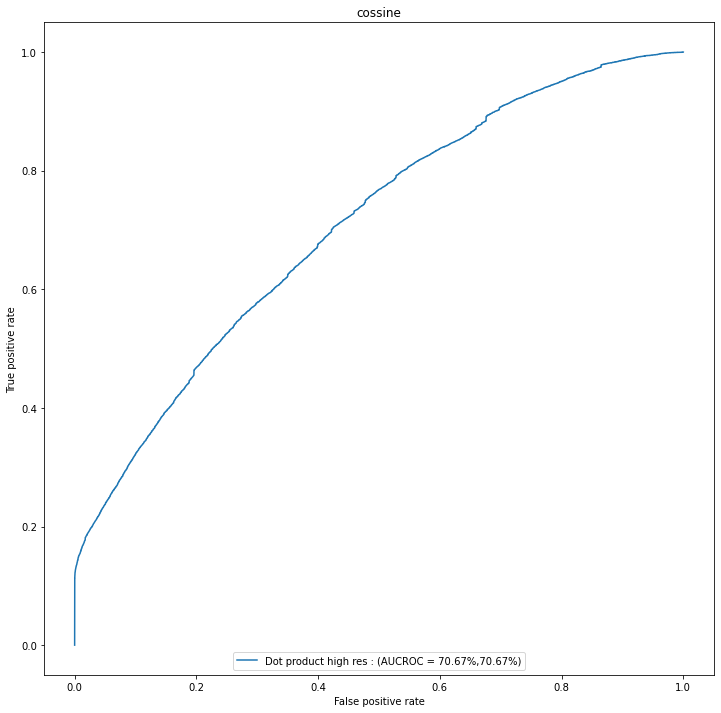

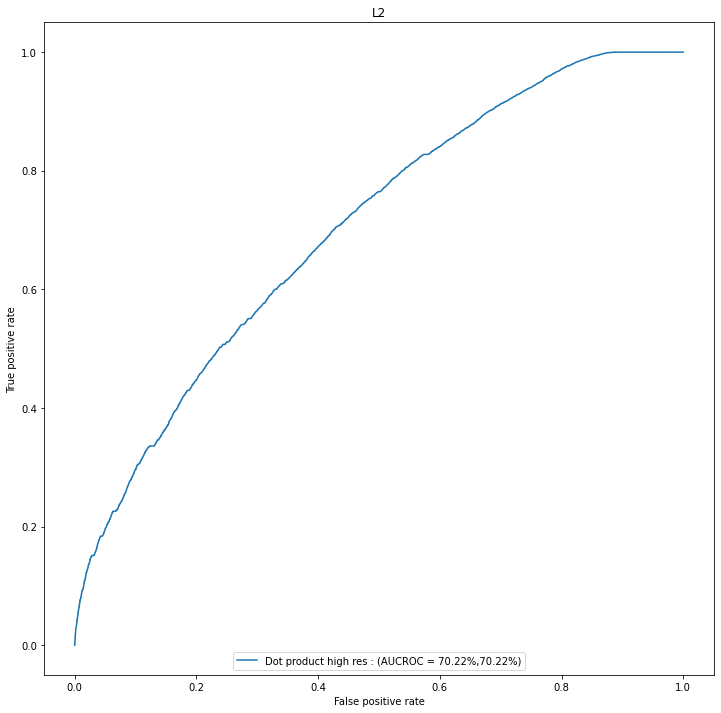

In [32]:
def form(pos_li, neg_li, title=""):
        labs = [0] * len(pos_li) + [1] * len(neg_li)
        dist = np.concatenate((neg_li, pos_li), axis=0)
        fpr, tpr, thresh = roc_curve(labs, dist, pos_label=1)

        width = 12
        fig, ax = plt.subplots(figsize=(width, width), facecolor='w')
        ax.plot(fpr, tpr,
                label=f'Dot product high res : (AUCROC = {auc(fpr, tpr):.2%},{roc_auc_score(labs, dist):.2%})')
        ax.legend(loc='lower center')
        ax.set_xlabel('False positive rate')
        ax.set_ylabel('True positive rate')
        ax.set_title(title)
        plt.show()
form(pos, neg, "cossine")
form(pos_d, neg_d, "L2")